<a href="https://colab.research.google.com/github/biku1998/Driver_Activity_Detection/blob/master/Driver_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Distracted Driver Detection

**Kaggle challenge link here :** <a href = "https://www.kaggle.com/c/state-farm-distracted-driver-detection/data">here</a>

We've all been there: a light turns green and the car in front of you doesn't budge. Or, a previously unremarkable vehicle suddenly slows and starts swerving from side-to-side.

When you pass the offending driver, what do you expect to see? You certainly aren't surprised when you spot a driver who is texting, seemingly enraptured by social media, or in a lively hand-held conversation on their phone.

<img src = "https://storage.googleapis.com/kaggle-competitions/kaggle/5048/media/drivers_statefarm.png">

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

State Farm hopes to improve these alarming statistics, and better insure their customers, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?

In [0]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import albumentations
from torchvision import transforms, utils,models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import glob
from PIL import Image
import PIL
import matplotlib.image as mpimg
import copy
import pretrainedmodels
import torchvision
import torch.optim as optim

In [0]:
os.listdir()

['.ipynb_checkpoints', 'data', 'Driver_activity_recognition.ipynb', 'Models']

In [0]:
os.listdir("./data/state-farm-distracted-driver-detection/")

['driver_imgs_list.csv', 'imgs', 'sample_submission.csv']

In [0]:
os.listdir("./data/state-farm-distracted-driver-detection/imgs/")

['test', 'train']

In [0]:
os.listdir("./data/state-farm-distracted-driver-detection/imgs/train/")

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [0]:
# let's make a dir to save the trained models

# os.mkdir("./Models")

In [0]:
classes = {
0: "safe driving",
1: "texting - right",
2: "talking on the phone - right",
3: "texting - left",
4: "talking on the phone - left",
5: "operating the radio",
6: "drinking",
7: "reaching behind",
8: "hair and makeup",
9: "talking to passenger"}

In [0]:
gpu = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(gpu)

cuda:0


In [0]:
transforms_full = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [0]:
full_data_dataset = torchvision.datasets.ImageFolder("./data/state-farm-distracted-driver-detection/imgs/train/",
                                                     transform = transforms_full)

In [0]:
len(full_data_dataset)

22424

In [0]:
train_size = int(0.9 * len(full_data_dataset))
val_size = len(full_data_dataset) - train_size

In [0]:
train_data, validation_data = random_split(full_data_dataset, [train_size, val_size])

In [0]:
len(train_data)

20181

In [0]:
len(validation_data)

2243

In [0]:
# let's show some datapoints using a small batch-size 

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 4,shuffle=False)

In [0]:
i = iter(train_loader)

images,labels = i.next()

print(images.shape)
print(labels.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [0]:
def imshow(img,label):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label.item()])
    plt.show()

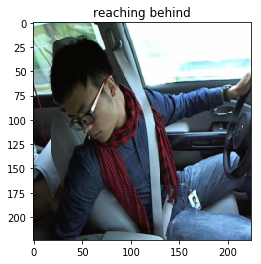

In [0]:
idx = 2
imshow(images[idx],labels[idx])

In [0]:
class Model_ResNet_50(nn.Module):

    def __init__(self,use_pretrained = False,output_classes=10,freeze_params = False):
        super(Model_ResNet_50,self).__init__()

        if use_pretrained:
            self.base_model_arc  = models.resnet50(pretrained = True)
        else:
            self.base_model_arc = models.resnet50(pretrained = False)
            
        if freeze_params:
            for param in self.base_model_arc.parameters():
                param.requires_grad = False
                
        last_layer_in_feature = self.base_model_arc.fc.in_features
        self.base_model_arc.fc = nn.Linear(last_layer_in_feature, output_classes)
            
    def forward(self,x):
        y = self.base_model_arc(x)
        return y

In [0]:
MODEL_ZOO = {
    'resent_50':Model_ResNet_50
}

In [0]:
# let's test the model on sample batch
model_resnet_50 = MODEL_ZOO['resent_50'](use_pretrained = True)
model_resnet_50(images)

tensor([[ 0.3447, -0.0175, -0.0321,  0.1143,  0.1106,  0.0175, -0.3251, -0.2075,
          0.3174,  0.2712],
        [ 0.1268, -0.0769,  0.1312, -0.0758,  0.2969, -0.0812, -0.1600, -0.3880,
          0.6303,  0.0847],
        [ 0.2754,  0.0053,  0.2600,  0.3230,  0.2623,  0.1271, -0.0401, -0.2787,
          0.3617,  0.1312],
        [ 0.1898, -0.2893, -0.1614, -0.0823,  0.2221, -0.0315, -0.3977, -0.2345,
          0.5393,  0.2571]], grad_fn=<AddmmBackward>)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in tqdm(dataloader,leave = False):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
def train(model,epochs,trainloader,testloader,device):

    loss_epoch_arr = []
    max_epochs = epochs
    best_model = None

    min_loss = 1000

    n_iters = np.ceil(50000/batch_size)

    for epoch in range(max_epochs):

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(model.state_dict()) # saving the model-parameter space.
                print('Min loss %0.2f' % min_loss)

            if i % 100 == 0:
                print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

            del inputs, labels, outputs
            torch.cuda.empty_cache()

            loss_epoch_arr.append(loss.item())

        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
            epoch, max_epochs, 
            evaluation(testloader, model), evaluation(trainloader, model)))


    plt.plot(loss_epoch_arr)
    plt.title("Train-Loss plot")
    plt.show()
    return best_model

Min loss 2.29
Iteration: 0/782, Loss: 2.29
Min loss 2.26
Min loss 2.23
Min loss 2.23
Min loss 2.20
Min loss 2.18
Min loss 2.10
Min loss 2.07
Min loss 2.05
Min loss 2.01
Min loss 2.01
Min loss 1.99
Min loss 1.92
Iteration: 100/782, Loss: 2.00
Min loss 1.87
Min loss 1.84
Min loss 1.80
Min loss 1.77
Min loss 1.74
Min loss 1.74
Min loss 1.69
Iteration: 200/782, Loss: 1.80
Min loss 1.63
Min loss 1.60
Min loss 1.59
Min loss 1.57
Min loss 1.53
Min loss 1.53
Min loss 1.50
Min loss 1.47
Iteration: 300/782, Loss: 1.47


Epoch: 0/1, Test acc: 57.78, Train acc: 60.26


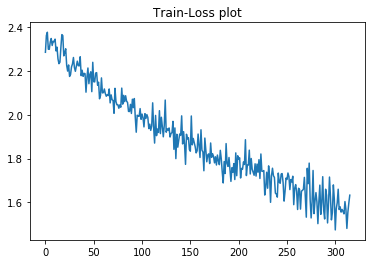

In [0]:
####### STAGE - 1 Training 

model_resnet_50 = MODEL_ZOO['resent_50'](use_pretrained = True,freeze_params = True)
model_resnet_50 = model_resnet_50.to(device)

batch_size = 64
epochs = 1
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_resnet_50.parameters(), lr=0.01)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(validation_data,batch_size = batch_size,shuffle = True)

best_model_resent_50 = train(model_resnet_50,epochs,train_loader,val_loader,device)

In [0]:
#### STAGE -1 SAVE the model

# let's save the model we have trained.

model_resnet_50.load_state_dict(best_model_resent_50)

torch.save(model_resnet_50.state_dict(),"./Models/resnet_50_stage_1.pth")


Min loss 1.61
Iteration: 0/1563, Loss: 1.61
Min loss 1.56
Min loss 1.43
Min loss 1.36
Min loss 1.22
Min loss 1.21
Min loss 1.19
Min loss 1.19
Min loss 1.19
Min loss 1.03
Min loss 1.00
Min loss 0.99
Min loss 0.82
Iteration: 100/1563, Loss: 1.01
Min loss 0.78
Min loss 0.76
Min loss 0.70
Min loss 0.68
Min loss 0.65
Min loss 0.65
Min loss 0.65
Min loss 0.65
Min loss 0.58
Min loss 0.58
Min loss 0.45
Iteration: 200/1563, Loss: 0.60
Min loss 0.45
Min loss 0.33
Min loss 0.23
Iteration: 300/1563, Loss: 0.47
Min loss 0.21
Iteration: 400/1563, Loss: 0.35
Min loss 0.20
Min loss 0.19
Min loss 0.16
Min loss 0.16
Min loss 0.14
Iteration: 500/1563, Loss: 0.23
Min loss 0.13
Min loss 0.12
Iteration: 600/1563, Loss: 0.27
Min loss 0.11


Epoch: 0/1, Test acc: 95.10, Train acc: 95.29


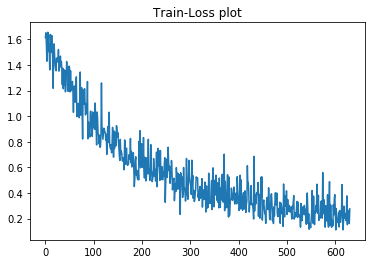

In [0]:
####### STAGE - 2 Training ,load the trained one and re-train

model_resnet_50 = MODEL_ZOO['resent_50'](use_pretrained = False,freeze_params = False)
model_resnet_50 = model_resnet_50.to(device)

model_resnet_50.load_state_dict(torch.load("./Models/resnet_50_stage_1.pth"))

model_resnet_50.train()

batch_size = 32
batch_size_val = 32
epochs = 1
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_resnet_50.parameters(), lr=0.001,momentum = 0.6,weight_decay = 0.001)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(validation_data,batch_size = batch_size_val,shuffle = True)

best_model_resent_50 = train(model_resnet_50,epochs,train_loader,val_loader,device)

In [0]:
#### STAGE -2 SAVE the model

# let's save the model we have trained.

model_resnet_50.load_state_dict(best_model_resent_50)

torch.save(model_resnet_50.state_dict(),"./Models/resnet_50_stage_2.pth")

**Inference**

In [0]:
def infer(model,input_,label,device):
    model = model.to(device)
    model.eval()
    imshow(input_,label)
    input_ = input_.to(device)
    output = model(input_.unsqueeze(0)).cpu().detach().numpy()
    output_class = classes[np.argmax(output)]
    print(f"Model output: {output_class}")
    

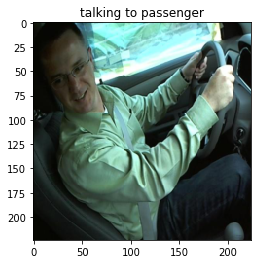

Model output: talking to passenger


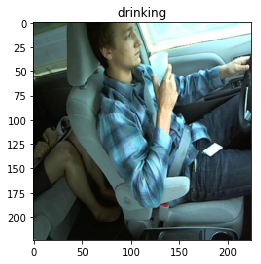

Model output: drinking


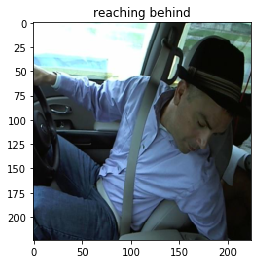

Model output: reaching behind


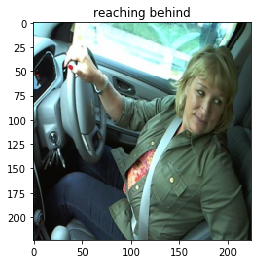

Model output: reaching behind


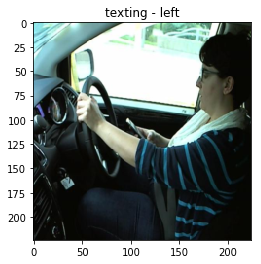

Model output: texting - left


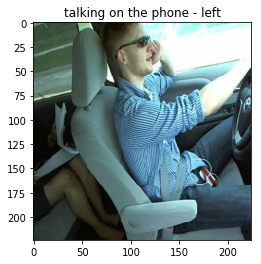

Model output: talking on the phone - left


In [0]:
val_loader = torch.utils.data.DataLoader(validation_data,batch_size = 256,shuffle = True)

i = iter(val_loader)

images,labels = i.next()
print()
for i in range(6):
    infer(model_resnet_50,images[i],labels[i],device)

### Creating submission file

In [0]:
# i think we have got a pretty good model

# let's create our test_data and create a submission file

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.jpg')
        self.transform = transform
        self.image_ids = [i.split("\\")[-1].strip() for i in self.image_paths]

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index])
        if self.transform is not None:
            x = self.transform(x)

        return {
            "image":x,
            "image_id":self.image_ids[index]
        }

    def __len__(self):
        return len(self.image_paths)

In [0]:
test_data_path = "./data/state-farm-distracted-driver-detection/imgs/test/"

In [0]:
transforms_test = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [0]:
test_dataset = TestDataset(test_data_path,transforms_test)

In [0]:
len(test_dataset)

79726

In [0]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 32)

In [0]:
i = iter(test_loader)

d = i.next()

d['image'].shape

torch.Size([32, 3, 224, 224])

In [0]:
def create_submission_df(model,test_loader,device):
    predictions = []
    
    model.to(device)
    model.eval()
    
    for data in tqdm(test_loader,unit = " image"):
        inputs,image_ids = data['image'],data['image_id']
        
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        
        for ii,im_id in enumerate(image_ids):
            predictions.append((im_id,outputs[ii].cpu().detach().numpy()))
    return predictions

In [0]:
model_resnet_50 = MODEL_ZOO['resent_50'](use_pretrained = False,freeze_params = False)

print(model_resnet_50.load_state_dict(torch.load("./Models/resnet_50_stage_2.pth")))

<All keys matched successfully>


In [0]:
sub_tuples = create_submission_df(model_resnet_50,test_loader,device)

In [0]:
torch.cuda.empty_cache()

In [0]:
df_data = []

In [0]:
for i,j in tqdm(sub_tuples):
    d = []
    d.append(i)
    d.append(np.argmax(j))
    df_data.append(d)

In [0]:
df_data[:3]

[['img_1.jpg', 5], ['img_10.jpg', 5], ['img_100.jpg', 0]]

In [0]:
df_sub = pd.DataFrame(data = df_data,columns = ["img","labels_index"])

In [0]:
df_sub.head()

,img,labels_index
0,img_1.jpg,5
1,img_10.jpg,5
2,img_100.jpg,0
3,img_1000.jpg,8
4,img_100000.jpg,3


In [0]:
ohe_df = pd.get_dummies(df_sub['labels_index'])

In [0]:
df_sub = df_sub.join(ohe_df)

In [0]:
df_sub.head()

,img,labels_index,0,1,2,3,4,5,6,7,8,9
0,img_1.jpg,5,0,0,0,0,0,1,0,0,0,0
1,img_10.jpg,5,0,0,0,0,0,1,0,0,0,0
2,img_100.jpg,0,1,0,0,0,0,0,0,0,0,0
3,img_1000.jpg,8,0,0,0,0,0,0,0,0,1,0
4,img_100000.jpg,3,0,0,0,1,0,0,0,0,0,0


In [0]:
df_sub.drop('labels_index',axis = 1,inplace = True)

df_sub.columns = ["img","c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]

In [0]:
df_sub.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0,0,0,0,0,1,0,0,0,0
1,img_10.jpg,0,0,0,0,0,1,0,0,0,0
2,img_100.jpg,1,0,0,0,0,0,0,0,0,0
3,img_1000.jpg,0,0,0,0,0,0,0,0,1,0
4,img_100000.jpg,0,0,0,1,0,0,0,0,0,0


In [0]:
os.mkdir("./Submissions")

In [0]:
df_sub.to_csv("./Submissions/submission_2.csv",index = False)